# Практика #1 — Часть 1: База ML и аналитическая линейная регрессия (1D → 2D → матрицы)

## 0. Подготовка окружения

In [ ]:
#!pip install -r requirements.txt

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

rng = np.random.default_rng(42)
np.set_printoptions(precision=4, suppress=True)



## 1. Базовые понятия ML
Мы хотим построить **правило предсказания** по примерам, чтобы на новых объектах получать ответы, близкие к истине.



### 1.1 Данные и обозначения
- Имеется выборка из $n$ примеров: $\{(x_i, y_i)\}_{i=1}^n$.  
- $x_i \in \mathbb{R}^d$ — вектор признаков, $d$ — число признаков.  
- $y_i$ — целевая переменная (в регрессии — число).  
- Матрица признаков $X \in \mathbb{R}^{n\times d}$ — строки это объекты, столбцы — признаки.  
- Вектор ответов $y \in \mathbb{R}^{n\times 1}$.


In [2]:

X_demo = np.array([[1.2, -0.3],
                   [0.4,  2.1],
                   [-1.0, 0.7],
                   [0.0,  0.5]])
y_demo = np.array([[2.0],
                   [3.1],
                   [0.2],
                   [0.7]])
print("Форма X:", X_demo.shape, " Форма y:", y_demo.shape)  # (n,d), (n,1)


Форма X: (4, 2)  Форма y: (4, 1)



### 1.2 Модель, параметры, предсказание
**Модель** — это функция $f(x;\theta)$, задающая предсказание $\hat y = f(x;\theta)$ для данного $x$.  
- $\theta$ — параметры модели (настраиваются по данным).  
**Пример (линейная модель):**
- $d=1$: $\hat y = wx + b$.
- $d>1$: $\hat y = x^\top w + b = \sum_{j=1}^d x_j w_j + b$.


In [3]:

# Ручной расчёт предсказания линейной модели (d=2)
x = np.array([2.0, -1.0])
w = np.array([0.5, 0.3])
b = 1.2
print("Предсказание:", x @ w + b)


Предсказание: 1.9


### 1.3 Потеря (loss) и метрика (metric) в регрессии

В задачах регрессии нужно чётко различать два понятия:

- **Функция потерь (loss function)** — то, что *минимизируется моделью при обучении*.
- **Метрика качества (evaluation metric)** — то, чем мы *оцениваем модель после обучения* и сравниваем разные модели.

Эти вещи связаны, но **не обязаны совпадать**.  
Потеря влияет на обучение и параметры модели, метрика — на интерпретацию качества.

---

#### 1.3.1 Функция потерь

Пусть модель выдаёт предсказания  
$\hat y_i = f(x_i; \theta)$,  
а истинные значения равны $y_i$.

**Потеря на одном примере** — это число  
$\ell(\hat y_i, y_i)$,  
которое показывает, насколько сильно предсказание $\hat y_i$ отличается от истинного $y_i$.

**Средняя потеря (эмпирический риск)** на обучающей выборке:
$$
L(\theta) = \frac{1}{n} \sum_{i=1}^n \ell(\hat y_i, y_i).
$$

При обучении мы выбираем параметры
$$
\theta^* = \arg\min_\theta L(\theta).
$$

То есть **обучение = поиск параметров, минимизирующих среднюю потерю**.

Выбор функции потерь влияет на:

- чувствительность к выбросам;
- форму «ландшафта» $L(\theta)$ (выпуклость, гладкость);
- удобство аналитического решения (для линейной регрессии — нормальные уравнения);
- статистические свойства оценок (какое распределение ошибок считается «нормальным» для модели).

---

#### 1.3.2 Основные функции потерь в регрессии

##### (a) MSE — mean squared error

Потеря на одном примере:
$$
\ell_{\text{MSE}}(\hat y, y) = (\hat y - y)^2.
$$

Средняя потеря:
$$
L_{\text{MSE}} = \frac{1}{n} \sum_{i=1}^n (\hat y_i - y_i)^2.
$$

Особенности:

- **усиливает большие ошибки**: если ошибка увеличилась в $k$ раз, вклад в MSE увеличивается в $k^2$ раз;
- **гладкая и дифференцируемая** по $\hat y$ — удобно для аналитики и градиентных методов;
- в линейной регрессии с MSE получаем **аналитическое решение** (метод наименьших квадратов, МНК);
- статистически оптимальна, если ошибки имеют нормальное распределение с одинаковой дисперсией:
  $$
  \varepsilon_i = y_i - \hat y_i \sim \mathcal{N}(0,\sigma^2).
  $$

MSE — **стандартная** функция потерь для линейной регрессии.

---

##### (b) MAE — mean absolute error

Потеря на одном примере:
$$
\ell_{\text{MAE}}(\hat y, y) = |\hat y - y|.
$$

Средняя потеря:
$$
L_{\text{MAE}} = \frac{1}{n} \sum_{i=1}^n |\hat y_i - y_i|.
$$

Особенности:

- менее чувствительна к выбросам, чем MSE (штраф линейный, а не квадратичный);
- минимум MAE достигается при **медиане** распределения, а не при среднем;
- функция не дифференцируема в точке $0$, но на практике это редко мешает.

Интуитивно: MAE — это «средний модуль ошибки».

---

##### (c) Huber loss

Huber loss — компромисс между MSE и MAE.

Обозначим ошибку $r = \hat y - y$. При некотором пороге $\delta > 0$:

$$
\ell_\delta(r) =
\begin{cases}
\dfrac12 r^2, & \text{если } |r| \le \delta, \\
\delta\bigl(|r| - \dfrac12\delta\bigr), & \text{если } |r| > \delta.
\end{cases}
$$

Особенности:

- для **малых ошибок** ведёт себя как MSE (квадратично);
- для **больших ошибок** ведёт себя как MAE (линейно);
- уменьшает влияние сильных выбросов, **сохраняя гладкость** около нуля.

Практически: хороша, когда есть выбросы, но хочется более «мягкой» версии MSE, а не чистой MAE.

---

##### (d) Quantile loss (pinball loss)

Используется в **квантильной регрессии**, когда мы хотим предсказывать не среднее, а определённый квантиль (например, $90\%$-перцентиль).

Для квантиля $\tau \in (0,1)$:

$$
\ell_\tau(\hat y, y) =
\begin{cases}
\tau (y - \hat y), & \text{если } y > \hat y, \\
(1 - \tau)(\hat y - y), & \text{если } y \le \hat y.
\end{cases}
$$

Интуиция:

- если $\tau = 0{.}5$, это даёт медианную регрессию;
- если $\tau = 0{.}9$, модель стремится «быть выше» наблюдений, чтобы $90\%$ точек лежали ниже предсказания.

---

#### 1.3.3 Метрики качества (evaluation metrics)

**Метрика** — это функция, которая принимает на вход всю выборку предсказаний и истинных значений и выдаёт **одну числовую оценку качества**:

$$
\text{metric} = M\bigl(\{(y_i,\hat y_i)\}_{i=1}^n\bigr).
$$

Важные отличия от потерь:

- метрика **не обязана** быть дифференцируемой;
- метрика **не участвует напрямую** в обучении (кроме специальных случаев), она используется *после*;
- выбор метрики зависит от того, **как принято оценивать качество в конкретной задаче**.

Ниже перечислены основные метрики для регрессии.

---

##### (a) MSE и RMSE как метрики

Формула MSE как метрики та же:
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (\hat y_i - y_i)^2.
$$

Часто используют **RMSE** — корень из MSE:
$$
\text{RMSE} = \sqrt{\text{MSE}}.
$$

Почему RMSE удобен:

- имеет **те же единицы измерения**, что и $y$ (например, «градусы», «рубли», «метры»);
- проще интерпретируется: «средняя ошибка примерно $X$ единиц».

---

##### (b) MAE как метрика

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^n |\hat y_i - y_i|.
$$

Интерпретация:

- «в среднем мы ошибаемся на $X$ единиц».

Плюсы:

- очень понятна для заказчиков;
- менее чувствительна к выбросам, чем MSE/RMSE.

Минусы:

- не так сильно «наказывает» крупные ошибки, как MSE/RMSE.

---

##### (c) MedAE — median absolute error

$$
\text{MedAE} = \operatorname{median}_{i}\bigl(|\hat y_i - y_i|\bigr).
$$

Особенности:

- **максимально устойчива** к выбросам: один или несколько экстремальных объектов почти не меняют значение MedAE;
- полезна, когда данные сильно зашумлены или распределение ошибок асимметрично.

Интерпретация: «половина ошибок по модулю не превышает значение MedAE».

---

##### (d) MAPE — mean absolute percentage error

$$
\text{MAPE} = \frac{100}{n} \sum_{i=1}^n \left| \frac{y_i - \hat y_i}{y_i} \right|\%.
$$

Интерпретация:

- «в среднем мы ошибаемся на $X\%$».

Проблемы:

- плохо определена, когда $y_i$ близки к нулю (деление на $y_i$);
- сильно «штрафует» ошибки на малых $y_i$.

Сферы применения:

- прогнозирование продаж, спроса, трафика — там, где **проценты** понятнее абсолютных величин.

---

##### (e) $R^2$ — коэффициент детерминации

Определяется как
$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat y_i)^2}{\sum_{i=1}^n (y_i - \bar y)^2},
$$
где
$$
\bar y = \frac{1}{n} \sum_{i=1}^n y_i
$$
— среднее по выборке.

Интерпретация:

- знаменатель — это качество «тривиальной» модели $\hat y = \bar y$ (все предсказания = среднее);
- числитель — суммарная квадратичная ошибка нашей модели;
- $R^2$ показывает, **насколько модель лучше, чем предсказывать среднее**.

Типичные случаи:

- $R^2 \approx 1$: модель почти идеально объясняет вариацию $y$;
- $R^2 \approx 0$: модель примерно как тривиальная константа;
- $R^2 < 0$: модель хуже, чем просто $\hat y = \bar y$.

---

#### 1.3.4 Когда какую потерю и метрику использовать?

Небольшая «карта выбора» для регрессии:

| Ситуация / данные                         | Потеря (при обучении) | Метрики (для отчёта)          |
|-------------------------------------------|------------------------|--------------------------------|
| Ошибки примерно нормальны, без выбросов  | MSE                    | RMSE, $R^2$, MSE              |
| Есть заметные выбросы                    | MAE или Huber          | MAE, MedAE, иногда $R^2$      |
| Нужна гладкость для градиентных методов  | MSE или Huber          | RMSE                          |
| Важна интерпретация «в процентах»        | (обычно MSE/MAE)       | MAPE                          |
| Хотим предсказывать квантиль             | Quantile loss          | квантильные метрики, MedAE    |

---

#### 1.3.5 Главное, что нужно запомнить

- **Потеря (loss)** — это то, что минимизируется при обучении (задаёт правила подгона параметров).  
- **Метрика (metric)** — это то, чем мы измеряем итоговое качество и сравниваем модели.  
- В линейной регрессии **MSE** — стандартная функция потерь, т.к. даёт красивое аналитическое решение и хорошо работает при нормальных ошибках.  
- Для отчётов часто используют **RMSE** (интерпретируемый масштаб), **MAE** (понятный «средний модуль ошибки») и **$R^2$** (насколько модель лучше константы).


In [4]:

y_true = np.array([3.0, 2.0, 4.0, 5.0])
y_pred = np.array([2.8, 2.2, 3.9, 4.7])
print("MSE:", mean_squared_error(y_true, y_pred))
print("R^2:", r2_score(y_true, y_pred))


MSE: 0.04500000000000001
R^2: 0.964


Влияние выброса на метрики (мини-демо):

=== Без выброса ===
MSE: 8.216321320169156
MAE: 2.224234500342315
MedAE: 1.9410949390960752
R^2: 0.9120858660766197

=== С выбросом ===
MSE: 93.25611642249778
MAE: 3.424234500342316
MedAE: 1.9410949390960752
R^2: 0.5466661673290363


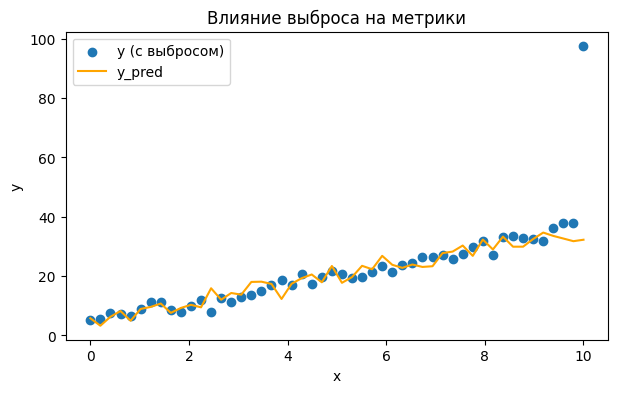

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

rng = np.random.default_rng(0)

# данные без выбросов
x = np.linspace(0, 10, 50)
y = 3*x + 5 + rng.normal(0, 2, size=x.size)

# модель "почти правильная"
y_pred = 3*x + 5 + rng.normal(0, 2, size=x.size)

# копии с добавлением выброса в последнюю точку
y_out = y.copy()
y_out[-1] += 60  # огромный выброс
y_pred_out = y_pred.copy()

print("=== Без выброса ===")
print("MSE:", mean_squared_error(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("MedAE:", median_absolute_error(y, y_pred))
print("R^2:", r2_score(y, y_pred))

print("\n=== С выбросом ===")
print("MSE:", mean_squared_error(y_out, y_pred_out))
print("MAE:", mean_absolute_error(y_out, y_pred_out))
print("MedAE:", median_absolute_error(y_out, y_pred_out))
print("R^2:", r2_score(y_out, y_pred_out))

plt.figure(figsize=(7,4))
plt.scatter(x, y_out, label="y (с выбросом)")
plt.plot(x, y_pred_out, label="y_pred", color="orange")
plt.legend()
plt.title("Влияние выброса на метрики")
plt.xlabel("x"); plt.ylabel("y")
plt.show()



## 2. Линейная регрессия в 1D: полный вывод формулы
**Модель:** $\hat y_i = wx_i + b$.  
**Функция стоимости:** $$L(w,b) = \frac{1}{n}\sum_{i=1}^n (wx_i + b - y_i)^2.$$
Найдём $w^*, b^*$, минимизирующие $L$.



### 2.1 Производные и нормальные уравнения
Обозначим $e_i=wx_i + b - y_i$. Тогда $L=\tfrac{1}{n}\sum e_i^2$ и
$$\frac{\partial L}{\partial w} = \frac{2}{n}\sum e_i x_i,\qquad
\frac{\partial L}{\partial b} = \frac{2}{n}\sum e_i.$$
Приравниваем к нулю:

\begin{cases}
\sum (wx_i + b - y_i) x_i = 0,\\
\sum (wx_i + b - y_i) = 0.
\end{cases}

После раскрытия получаем систему

\begin{cases}
w\sum x_i^2 + b\sum x_i = \sum x_i y_i,\\
w\sum x_i + b\,n = \sum y_i.
\end{cases}



### 2.2 Пошаговое решение системы (детально)
Обозначим $S_x=\sum x_i$, $S_y=\sum y_i$, $S_{xx}=\sum x_i^2$, $S_{xy}=\sum x_i y_i$. Тогда:

\begin{cases}
w S_{xx} + b S_x = S_{xy},\\
w S_x + b n = S_y.
\end{cases}

1) Из второго уравнения: $b = (S_y - w S_x)/n$.  
2) Подставляем в первое: $w S_{xx} + \big((S_y - w S_x)/n\big) S_x = S_{xy}$.  
3) Сгруппируем по $w$:
$$w\Big(S_{xx} - \frac{S_x^2}{n}\Big) = S_{xy} - \frac{S_x S_y}{n}.$$
4) Делим и используем $\bar x=S_x/n$, $\bar y=S_y/n$:
$$w^* = \frac{S_{xy} - \frac{S_x S_y}{n}}{S_{xx} - \frac{S_x^2}{n}}
= \frac{\sum (x_i-\bar x)(y_i-\bar y)}{\sum (x_i-\bar x)^2} = \frac{\operatorname{Cov}(x,y)}{\operatorname{Var}(x)}$$

5) Возвращаемся к $b$: $b^* = \bar y - w^*\,\bar x$.

Это и есть **МНК (метод наименьших квадратов)**


In [6]:

# Числовая демонстрация (пошагово)
x = np.array([-2., -1., 0., 1., 2.])
y = np.array([-5.8, -1.9, 0.2, 2.1, 4.2])

n = x.size
Sx, Sy = x.sum(), y.sum()
Sxx, Sxy = (x**2).sum(), (x*y).sum()
x_bar, y_bar = Sx/n, Sy/n

w_star = (Sxy - Sx*Sy/n) / (Sxx - Sx**2/n)
b_star = y_bar - w_star * x_bar

print("Sx, Sy, Sxx, Sxy:", Sx, Sy, Sxx, Sxy)
print("x_bar, y_bar:", x_bar, y_bar)
print(f"w* = {w_star:.4f}, b* = {b_star:.4f}")

Sx, Sy, Sxx, Sxy: 0.0 -1.1999999999999984 10.0 24.0
x_bar, y_bar: 0.0 -0.23999999999999969
w* = 2.4000, b* = -0.2400


In [7]:
# Сравнение с lstsq
X_aug = np.vstack([x, np.ones_like(x)]).T
w_hat, *_ = np.linalg.lstsq(X_aug, y)
print("lstsq -> w,b:", w_hat)


lstsq -> w,b: [ 2.4  -0.24]


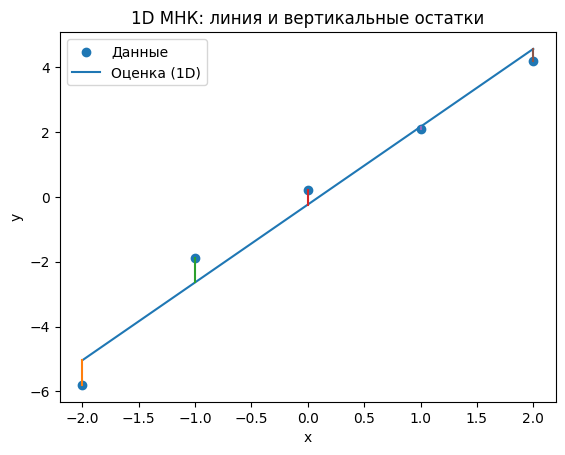

In [8]:

# Визуализация: линия и остатки
xx = np.linspace(x.min(), x.max(), 200)
yy = w_star*xx + b_star

plt.figure()
plt.scatter(x, y, label="Данные")
plt.plot(xx, yy, label="Оценка (1D)")
for xi, yi in zip(x, y):
    plt.plot([xi, xi], [yi, w_star*xi + b_star])
plt.xlabel("x"); plt.ylabel("y"); plt.title("1D МНК: линия и вертикальные остатки")
plt.legend(); plt.show()



Геометрический смысл (1D интуиция):

Мы выбираем такую прямую, чтобы сумма квадратов вертикальных отклонений была минимальна.
Это приводит к **ортогональности** в общем случае (см. далее матричную версию).



### 2.3 Поверхность потерь $L(w,b)$ (контуры и 3D)
Выпуклая «чаша» с единственным глобальным минимумом в $(w^*, b^*)$.


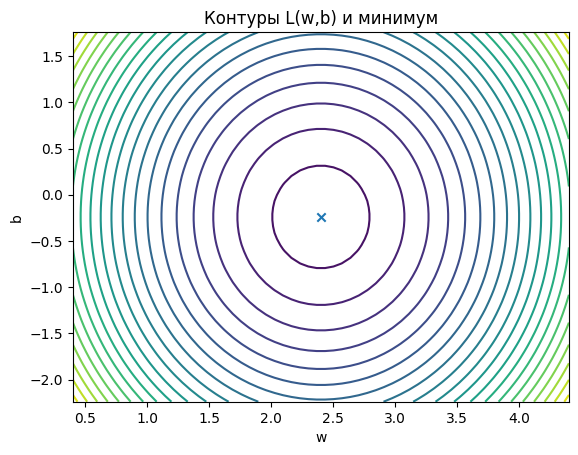

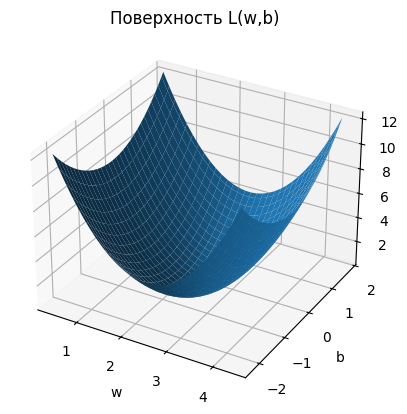

In [9]:

w_grid = np.linspace(w_star-2, w_star+2, 60)
b_grid = np.linspace(b_star-2, b_star+2, 60)
W, B = np.meshgrid(w_grid, b_grid)
L = np.zeros_like(W)
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        y_hat = W[i,j]*x + B[i,j]
        L[i,j] = np.mean((y_hat - y)**2)

plt.figure()
plt.contour(W, B, L, levels=20)
plt.scatter([w_star], [b_star], marker="x")
plt.xlabel("w"); plt.ylabel("b"); plt.title("Контуры L(w,b) и минимум")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W, B, L, linewidth=0, antialiased=True)
ax.set_xlabel("w"); ax.set_ylabel("b"); ax.set_zlabel("L")
ax.set_title("Поверхность L(w,b)")
plt.show()



### 2.4 Центрирование признака: почему удобно
Положим $x'_i = x_i - \bar x$. Тогда оптимальный сдвиг $b^* = \bar y$, а $w^*$ считаем по $x'$ как
$$w^* = \frac{\sum x'_i (y_i - \bar y)}{\sum (x'_i)^2}.$$
Это упрощает алгебру и улучшает численную стабильность.


In [10]:

x_c = x - x.mean()
w_star_c = ( (x_c*(y - y.mean())).sum() ) / ( (x_c**2).sum() )
b_star_c = y.mean()
print(f"Центрирование -> w*={w_star_c:.4f}, b*={b_star_c:.4f}")


Центрирование -> w*=2.4000, b*=-0.2400



## 3. Обобщение: 2 признака и матрицы
Теперь $x_i \in \mathbb{R}^2$, $\hat y_i = w_1 x_{i1} + w_2 x_{i2} + b$. В матричной форме добавим столбец единиц:
$$\tilde X = [X\;\;\mathbf{1}] \in \mathbb{R}^{n\times (d+1)}, \quad \tilde w = \begin{bmatrix}w\\b\end{bmatrix}, \quad \hat y = \tilde X\tilde w.$$



### 3.1 Вывод нормальных уравнений в матричной форме
$$L(\tilde w) = \frac{1}{n}\|\tilde X\tilde w - y\|_2^2 = \frac{1}{n}(\tilde X\tilde w - y)^\top(\tilde X\tilde w - y).$$
Градиент по $\tilde w$:
$$\nabla_{\tilde w} L = \frac{2}{n}\tilde X^\top(\tilde X\tilde w - y).$$
Приравнивая к нулю, получаем
$$(\tilde X^\top\tilde X)\tilde w = \tilde X^\top y.$$
Если $\tilde X^\top\tilde X$ обратима, то
$$\tilde w^* = (\tilde X^\top\tilde X)^{-1}\tilde X^\top y.$$

На практике вычисляем через решатель линейных систем или псевдообратную.

In [11]:

n = 200
X2 = rng.normal(0, 1, size=(n,2))
true_w = np.array([1.5, -2.0]); true_b = 0.7
y2 = (X2 @ true_w + true_b + rng.normal(0, 0.8, size=n)).reshape(-1,1)

X2_aug = np.hstack([X2, np.ones((n,1))])
w_hat, *_ = np.linalg.lstsq(X2_aug, y2)
w2_hat, b2_hat = w_hat[:2].ravel(), float(w_hat[2,0])
print("Оценка (2D): w_hat:", w2_hat, " b_hat:", b2_hat)


Оценка (2D): w_hat: [ 1.5904 -2.0374]  b_hat: 0.716050283164759


In [12]:
# Через solve (X^T X) w = X^T y
XtX = X2_aug.T @ X2_aug
Xty = X2_aug.T @ y2
w_solve = np.linalg.solve(XtX, Xty)  # предполагаем невырождённость
w_pinv = np.linalg.pinv(X2_aug) @ y2  # псевдообратная (SVD)

print("w_solve:", w_solve)
print()
print("w_pinv:", w_pinv)


w_solve: [[ 1.5904]
 [-2.0374]
 [ 0.7161]]

w_pinv: [[ 1.5904]
 [-2.0374]
 [ 0.7161]]



### 3.2 Геометрия проекции: матрица $H$
$$H = \tilde X(\tilde X^\top\tilde X)^{-1}\tilde X^\top,\quad \hat y = Hy,\quad r=y-\hat y.$$
Свойства: $H$ — проектор ($H^2=H$), остатки ортогональны столбцам $\tilde X$: $\tilde X^\top r=0$.


In [13]:

H = X2_aug @ np.linalg.solve(X2_aug.T @ X2_aug, X2_aug.T)
y2_hat = H @ y2
r = y2 - y2_hat

print("||H - H@H||:", np.linalg.norm(H - H@H))
print("Ортогональность: ||X^T r|| =", np.linalg.norm(X2_aug.T @ r))


||H - H@H||: 3.8400908381437585e-16
Ортогональность: ||X^T r|| = 5.66043918275631e-14



### 3.3 Диагностика и «помогающие» графики


MSE: 0.5714446587845637
R^2: 0.9256711121463986


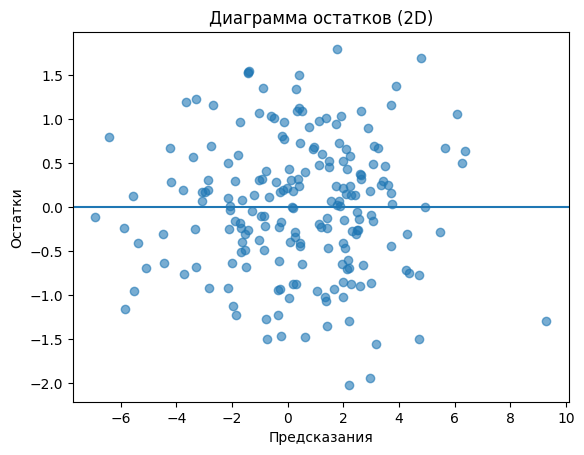

In [14]:

y2_pred = X2_aug @ w_hat
print("MSE:", mean_squared_error(y2, y2_pred))
print("R^2:", r2_score(y2, y2_pred))

plt.figure()
plt.scatter(y2_pred, y2 - y2_pred, alpha=0.6)
plt.axhline(0.0)
plt.xlabel("Предсказания"); plt.ylabel("Остатки"); plt.title("Диаграмма остатков (2D)")
plt.show()



### 3.4 Частные зависимости: $y$ vs $x_1$ и $y$ vs $x_2$


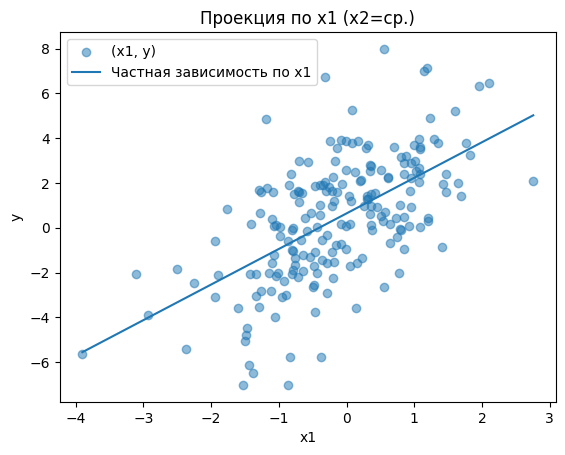

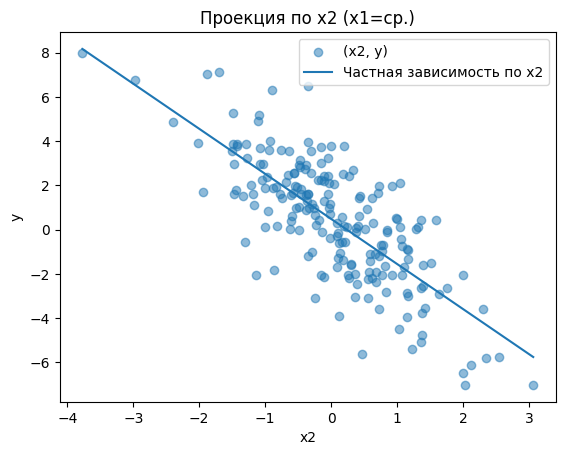

In [15]:

x1 = X2[:,0]; x2 = X2[:,1]
w1, w2 = w2_hat; b = b2_hat
x2_mean = x2.mean(); x1_mean = x1.mean()

xx1 = np.linspace(x1.min(), x1.max(), 200)
yy1 = w1*xx1 + w2*x2_mean + b

plt.figure()
plt.scatter(x1, y2, alpha=0.5, label="(x1, y)")
plt.plot(xx1, yy1, label="Частная зависимость по x1")
plt.xlabel("x1"); plt.ylabel("y"); plt.legend(); plt.title("Проекция по x1 (x2=ср.)")
plt.show()

xx2 = np.linspace(x2.min(), x2.max(), 200)
yy2p = w1*x1_mean + w2*xx2 + b

plt.figure()
plt.scatter(x2, y2, alpha=0.5, label="(x2, y)")
plt.plot(xx2, yy2p, label="Частная зависимость по x2")
plt.xlabel("x2"); plt.ylabel("y"); plt.legend(); plt.title("Проекция по x2 (x1=ср.)")
plt.show()



### 3.5 Практические замечания
- При коллинеарности признаков $(\tilde X^\top\tilde X)$ вырождается — используйте псевдообратную/регуляризацию.  
- Центрирование: $b^* = \bar y - w^\top \bar x$, а при $\bar x=0$ — $b^* = \bar y$.  
- Экстраполяция вне диапазона обучающих $x$ требует осторожности.


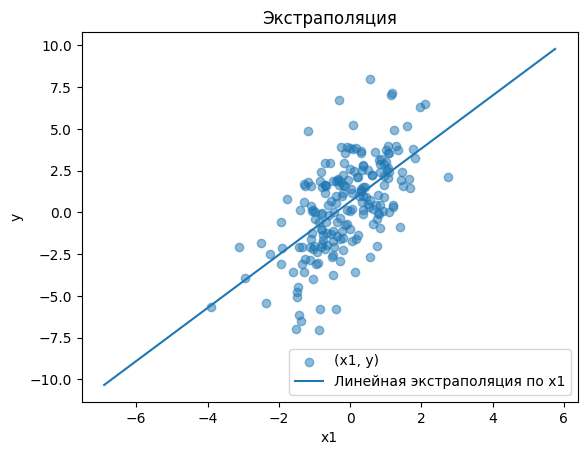

In [16]:

# Иллюстрация экстраполяции для x1 при фиксированном x2
x1_min, x1_max = x1.min(), x1.max()
xx1_far = np.linspace(x1_min-3, x1_max+3, 200)
yy1_far = w1*xx1_far + w2*x2_mean + b

plt.figure()
plt.scatter(x1, y2, alpha=0.5, label="(x1, y)")
plt.plot(xx1_far, yy1_far, label="Линейная экстраполяция по x1")
plt.legend(); plt.xlabel("x1"); plt.ylabel("y"); plt.title("Экстраполяция")
plt.show()


### 3.6 Необратимый случай: что делать, если $X^\top X$ вырожденная матрица?

В аналитическом решении линейной регрессии методом наименьших квадратов (МНК) мы приходим к нормальным уравнениям:

$$
X^\top X w = X^\top y,
$$

и при условии обратимости матрицы $X^\top X$ получаем решение:

$$
w^* = (X^\top X)^{-1} X^\top y.
$$

Но что делать, если $X^\top X$ **необратима**?

---

#### 3.6.1 Когда матрица $X^\top X$ оказывается вырожденной?

1. **Линейная зависимость признаков (коллинеарность)**  
   Тогда:
   $$
   \operatorname{rank}(X) < d,
   $$
   значит $X^\top X$ — сингулярна.

2. **Слишком мало объектов (случай \(d > n\))**  
   Тогда:
   $$
   \operatorname{rank}(X) \le n < d.
   $$

В обоих случаях инверсия $(X^\top X)^{-1}$ **не существует**, но сама задача минимизации:

$$
L(w) = \frac{1}{n}\|Xw - y\|_2^2
$$

остаётся корректной.

---

#### 3.6.2 Псевдообратная матрица Мура–Пенроуза

В этом случае решение МНК записывается через псевдообратную матрицу $X^+$:

$$
w^* = X^{+} y.
$$

Это решение:

- минимизирует MSE,
- имеет минимальную норму $ \|w\|_2 $,
- существует даже в вырожденных и прямоугольных случаях.

---

#### 3.6.3 Построение псевдообратной через SVD

Любую матрицу $X \in \mathbb{R}^{n \times d}$ можно разложить так:

$$
X = U \Sigma V^\top,
$$

где:

- $U$ — ортонормальная матрица размера $n \times n$,
- $V$ — ортонормальная матрица размера $d \times d$,
- $\Sigma$ — диагональная (прямоугольная) матрица сингулярных чисел:
  $$
  \Sigma = \operatorname{diag}(\sigma_1, \sigma_2, \dots, \sigma_r, 0, \dots, 0),
  $$
  при этом
  $$
  \sigma_1 \ge \sigma_2 \ge \dots \ge \sigma_r > 0.
  $$

Псевдообратная диагональной матрицы $\Sigma$ имеет вид:

$$
\Sigma^{+} = \operatorname{diag}\left(\frac{1}{\sigma_1}, \frac{1}{\sigma_2}, \dots, \frac{1}{\sigma_r}, 0, \dots, 0\right).
$$

Псевдообратная $X^{+}$:

$$
X^{+} = V \Sigma^{+} U^\top.
$$

Тогда решение МНК:

$$
w^* = X^{+} y = V \Sigma^{+} U^\top y.
$$

---

#### 3.6.4 Связь с обычным невырожденным случаем

Если все сингулярные числа положительны (матрица имеет полный ранг):

- $\Sigma$ обратима,
- $\Sigma^{+} = \Sigma^{-1}$,
- псевдообратная $X^{+}$ совпадает с:

$$
X^{+} = (X^\top X)^{-1} X^\top.
$$

То есть:

$$
w^* = X^{+} y
$$

является **обобщением** обычной формулы МНК, работающим и при вырожденности.

---

#### 3.6.5 Почему решение не единственно и что значит «минимально-нормовое»

Если матрица $X$ вырождена, уравнение:

$$
Xw = y
$$

может иметь:

- бесконечно много решений (если точно совместно),  
- или множество решений, минимизирующих $\|Xw - y\|_2^2$, но различающихся по норме $ \|w\|_2 $.

Псевдообратная выбирает единственное решение:

$$
w^* = \arg\min_w \{\|w\|_2 : w \text{ минимизирует } \|Xw - y\|_2^2\}.
$$

Это **минимально-нормовое решение**, обладающее лучшей устойчивостью.

---

#### Итог

- Невырожденный случай:
  $$
  w^* = (X^\top X)^{-1} X^\top y.
  $$
- Общий случай (вырожденный, прямоугольный, мало данных):
  $$
  w^* = X^{+} y, \quad \text{где } X^{+} = V \Sigma^{+} U^\top.
  $$

Это решение корректно и устойчиво в любых условиях.
